Epoch 0/50000, Total Loss: 2126.771484, PDE Loss: 142.097000, BC Loss: 1.984675, Metric x: 0.506845
Epoch 100/50000, Total Loss: 1276.487061, PDE Loss: 170.025101, BC Loss: 1.106462, Metric x: 0.509055
Epoch 200/50000, Total Loss: 599.188232, PDE Loss: 220.390350, BC Loss: 0.378798, Metric x: 0.513072
Epoch 300/50000, Total Loss: 298.914551, PDE Loss: 171.404770, BC Loss: 0.127510, Metric x: 0.501384
Epoch 400/50000, Total Loss: 185.085739, PDE Loss: 135.859421, BC Loss: 0.049226, Metric x: 0.488522
Epoch 500/50000, Total Loss: 171.959839, PDE Loss: 137.280991, BC Loss: 0.034679, Metric x: 0.485416
Epoch 600/50000, Total Loss: 167.095505, PDE Loss: 135.322098, BC Loss: 0.031773, Metric x: 0.484539
Epoch 700/50000, Total Loss: 162.903503, PDE Loss: 132.638016, BC Loss: 0.030265, Metric x: 0.483963
Epoch 800/50000, Total Loss: 158.734665, PDE Loss: 129.374069, BC Loss: 0.029361, Metric x: 0.483445
Epoch 900/50000, Total Loss: 153.470062, PDE Loss: 125.609283, BC Loss: 0.027861, Metric x:

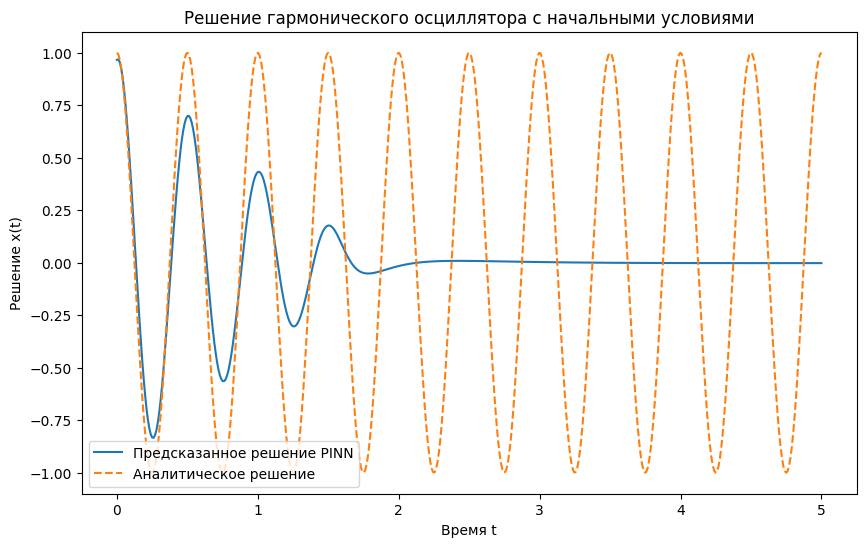

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Определяем модель PINN с использованием nn.Sequential
class PINNModel(nn.Module):
    def __init__(self, hidden_size=20):
        super(PINNModel, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.layers_stack(x)

# Функция для уравнения
def pde_second_order(x, t, omega):
    dxdt = torch.autograd.grad(outputs=x, inputs=t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(outputs=dxdt, inputs=t, grad_outputs=torch.ones_like(dxdt), create_graph=True)[0]
    F = torch.cos(omega * t)  # Внешняя сила
    residual = d2xdt2 + omega**2 * x - F  # Резидуал уравнения
    return residual, dxdt, d2xdt2

# Функция для вычисления метрик
def metric_data(a, b):
    return torch.mean((a - b)**2)

# Функция потерь с учетом начальных условий и весовых коэффициентов
def loss_fn(model, t, omega, x0_true, v0_true, weight_pde=1.0, weight_bc=1000.0):
    x = model(t)
    res, dxdt, d2xdt2 = pde_second_order(x, t, omega)
    loss_pde = metric_data(res, torch.zeros_like(res))

    # Поиск индексов, где t == 0
    inlet_mask = (t[:, 0] == 0.0)
    if inlet_mask.any():
        t0 = t[inlet_mask]
        x0_pred = model(t0)
        dxdt0 = torch.autograd.grad(outputs=x0_pred, inputs=t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0]

        # Вычисляем потери по начальному условию
        loss_bc_x = metric_data(x0_pred, x0_true)
        loss_bc_dxdt = metric_data(dxdt0, v0_true)
        loss_bc = loss_bc_x + loss_bc_dxdt
    else:
        loss_bc = torch.tensor(0.0, device=device)

    # Общая функция потерь с весовыми коэффициентами
    loss = weight_pde * loss_pde + weight_bc * loss_bc

    # Вычисление метрик для мониторинга
    x_true = x0_true * torch.sin(omega * t + torch.pi / 2)
    metric_x = metric_data(x, x_true)

    return loss, loss_pde, loss_bc, metric_x, x, dxdt, d2xdt2

# Функция обучения модели
def train_model(omega, t, x0_true, v0_true, epochs=50000, learning_rate=0.001):
    model = PINNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []
    loss_pde_history = []
    loss_bc_history = []
    metric_x_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_pde, loss_bc, metric_x, x, dxdt, d2xdt2 = loss_fn(model, t, omega, x0_true, v0_true)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        loss_pde_history.append(loss_pde.item())
        loss_bc_history.append(loss_bc.item())
        metric_x_history.append(metric_x.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Total Loss: {loss.item():.6f}, PDE Loss: {loss_pde.item():.6f}, BC Loss: {loss_bc.item():.6f}, Metric x: {metric_x.item():.6f}")

    return model, loss_history, loss_pde_history, loss_bc_history, metric_x_history, x, dxdt, d2xdt2

# Функция тестирования модели
def test_model(model, t):
    with torch.no_grad():
        x_pred = model(t)
    return x_pred

# Время и параметры для обучения
t = torch.linspace(0, 5, 500).reshape(-1, 1).to(device)  # Вектор времени
t.requires_grad = True
omega = 2 * np.pi * 2  # Частота

# Начальные условия
x0_true = torch.tensor(1.0).to(device)
v0_true = torch.tensor(1.0).to(device)

# Обучаем модель
model, loss_history, loss_pde_history, loss_bc_history, metric_x_history, x, dxdt, d2xdt2 = train_model(omega, t, x0_true, v0_true)

# Тестируем модель
x_pred = test_model(model, t)

# Визуализация результатов
import matplotlib.pyplot as plt

t_np = t.cpu().detach().numpy()
x_np = x_pred.cpu().detach().numpy()
x_true_np = (x0_true.cpu().numpy()) * np.sin(omega * t_np + np.pi / 2)

plt.figure(figsize=(10, 6))
plt.plot(t_np, x_np, label='Предсказанное решение PINN')
plt.plot(t_np, x_true_np, label='Аналитическое решение', linestyle='--')
plt.xlabel('Время t')
plt.ylabel('Решение x(t)')
plt.title('Решение гармонического осциллятора с начальными условиями')
plt.legend()
plt.show()
